## Importazione librerie

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error
shap.initjs()
import json
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from PyPDF2 import PdfReader
import re 
import csv
from rapidfuzz import process, fuzz
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from scipy.stats import chi2_contingency


## File completo con tutte le domande

In [4]:
dir=os.getcwd()
print(dir)

c:\Users\Maria Beatrice\Desktop\test\UNIVERSITA\SECONDO anno magistrale\BIGDATA\Big-Data-Analytics\Progetto Big Data


In [5]:
#df_preclinica = pd.read_csv(file_path("area_preclinica_2016_2019_finale.csv"))

# Usa il percorso assoluto per il file clinica
PRECLINICA_PATH= r"output\preclinica\area_preclinica_2016_2019_finale.csv"
CLINICA_PATH = r"output\clinica\area_clinica_2016_2019_finale.csv"
df_preclinica= pd.read_csv(PRECLINICA_PATH)
df_clinica = pd.read_csv(CLINICA_PATH)

df_finale = pd.concat([df_preclinica, df_clinica])
df_finale.to_csv("area_preclinica_clinica_2016_2019_finale.csv", index=False, encoding='utf-8')

# passaggio a jsonl
output_file = "area_preclinica_clinica_2016_2019_finale.jsonl"

# Apri file in scrittura
with open(output_file, "w", encoding="utf-8") as f:
    for _, row in df_finale .iterrows():
        # Costruisci dizionario nel formato richiesto
        json_obj = {
            "question": row["question"],
            "options": [
                {"A": row["A"]},
                {"B": row["B"]},
                {"C": row["C"]},
                {"D": row["D"]},
                {"E": row["E"]}
            ],
            "answer": row["answer"],
            "category": row["macro category"] ,
            "macro_category": row["category"]
        }
        # Scrivi ogni riga come JSON
        f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")


## estrazione sottocampione

In [6]:
sample = df_finale.sample(n=50, random_state=42)
sample.to_csv("sample.csv", index=False, encoding='utf-8')

# passaggio a jsonl
output_file = "sample.jsonl"

# Apri file in scrittura
with open(output_file, "w", encoding="utf-8") as f:
    for _, row in sample .iterrows():
        # Costruisci dizionario nel formato richiesto
        json_obj = {
            "question": row["question"],
            "options": [
                {"A": row["A"]},
                {"B": row["B"]},
                {"C": row["C"]},
                {"D": row["D"]},
                {"E": row["E"]}
            ],
            "answer": row["answer"],
            "category": row["macro category"] ,
            "macro_category": row["category"]
        }
        # Scrivi ogni riga come JSON
        f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")


## Apriamo il csv e creiamo una colonna index

In [7]:
df= pd.read_csv("area_preclinica_clinica_2016_2019_finale.csv")

df["index"] = range(len(df))

df=df[["index"] + [col for col in df.columns if col != "index"]]

df = df.drop(["id", "A", "B", "C", "D", "E"], axis=1)

# Mostra il risultato
df.head()

,index,question,answer,category,macro category
0,0,in una polmonite da staphylococcus aureus meti...,A,Area Preclinica 2016,farmacologia
1,1,i farmaci ipoglicemizzanti orali della classe ...,B,Area Preclinica 2016,farmacologia
2,2,"quale tra i seguenti farmaci antidiabetici, de...",D,Area Preclinica 2016,farmacologia
3,3,nello shock emorragico il trattamento iniziale...,A,Area Preclinica 2016,farmacologia
4,4,indicare quale dei seguenti farmaci antitumora...,A,Area Preclinica 2016,farmacologia


## Unire al dataset di interesse le risposte dei modelli


In [8]:
#Gemma
with open("custom_openai_google_gemma_3_27b_it_area_preclinica_clinica_2016_2019_finale_fast.json", "r", encoding="utf-8") as f:
    json_data_gemma = json.load(f)

# Crea un dizionario index → output
output_by_index_gemma = {entry["index"]: entry["output"] for entry in json_data_gemma["results"]}
print(output_by_index_gemma)

#Llama
with open("custom_openai_meta_llama_llama_4_maverick_area_preclinica_clinica_2016_2019_finale_fast.json", "r", encoding="utf-8") as f:
    json_data_llama = json.load(f)

# Crea un dizionario index → output
output_by_index_llama = {entry["index"]: entry["output"] for entry in json_data_llama["results"]}
print(output_by_index_llama)

## Mistral

with open("custom_openai_mistralai_mistral_small_3.2_24b_instruct_area_preclinica_clinica_2016_2019_finale_fast.json", "r", encoding="utf-8") as f:
    json_data_mistral = json.load(f)

# Crea un dizionario index → output
output_by_index_mistral = {entry["index"]: entry["output"] for entry in json_data_mistral["results"]}
print(output_by_index_mistral)


{0: 'A', 1: 'B', 2: 'D', 3: 'A', 4: 'A', 5: 'A', 6: 'E', 7: 'B', 8: 'E', 9: 'D', 10: 'A', 11: 'D', 12: 'C', 13: 'C', 14: 'D', 15: 'D', 16: 'C', 17: 'A', 18: 'D', 19: 'E', 20: 'E', 21: 'D', 22: 'A', 23: 'B', 24: 'D', 25: 'D', 26: 'B', 27: 'E', 28: 'B', 29: 'B', 30: 'C', 31: 'D', 32: 'A', 33: 'B', 34: 'C', 35: 'E', 36: 'D', 37: 'C', 38: 'C', 39: 'B', 40: 'A', 41: 'C', 42: 'E', 43: 'E', 44: 'A', 45: 'B', 46: 'B', 47: 'B', 48: 'A', 49: 'C', 50: 'E', 51: 'D', 52: 'D', 53: 'D', 54: 'B', 55: 'D', 56: 'D', 57: 'A', 58: 'B', 59: 'B', 60: 'C', 61: 'D', 62: 'B', 63: 'E', 64: 'B', 65: 'B', 66: 'E', 67: 'B', 68: 'B', 69: 'C', 70: 'D', 71: 'E', 72: 'A', 73: 'B', 74: 'B', 75: 'D', 76: 'C', 77: 'E', 78: 'A', 79: 'D', 80: 'A', 81: 'D', 82: 'E', 83: 'C', 84: 'D', 85: 'E', 86: 'B', 87: 'B', 88: 'D', 89: 'B', 90: 'E', 91: 'D', 92: 'D', 93: 'C', 94: 'B', 95: 'A', 96: 'C', 97: 'D', 98: 'D', 99: 'A', 100: 'C', 101: 'A', 102: 'B', 103: 'A', 104: 'C', 105: 'B', 106: 'C', 107: 'B', 108: 'D', 109: 'D', 110: 'A',

In [9]:
df.head()

,index,question,answer,category,macro category
0,0,in una polmonite da staphylococcus aureus meti...,A,Area Preclinica 2016,farmacologia
1,1,i farmaci ipoglicemizzanti orali della classe ...,B,Area Preclinica 2016,farmacologia
2,2,"quale tra i seguenti farmaci antidiabetici, de...",D,Area Preclinica 2016,farmacologia
3,3,nello shock emorragico il trattamento iniziale...,A,Area Preclinica 2016,farmacologia
4,4,indicare quale dei seguenti farmaci antitumora...,A,Area Preclinica 2016,farmacologia


In [10]:
df["gemma"] = df["index"].apply(lambda idx: output_by_index_gemma.get(idx, ""))
df["llama"] = df["index"].apply(lambda idx: output_by_index_llama.get(idx, ""))
df["mistral"] = df["index"].apply(lambda idx: output_by_index_mistral.get(idx, ""))
df.head()

,index,question,answer,category,macro category,gemma,llama,mistral
0,0,in una polmonite da staphylococcus aureus meti...,A,Area Preclinica 2016,farmacologia,A,A,A
1,1,i farmaci ipoglicemizzanti orali della classe ...,B,Area Preclinica 2016,farmacologia,B,B,B
2,2,"quale tra i seguenti farmaci antidiabetici, de...",D,Area Preclinica 2016,farmacologia,D,D,D
3,3,nello shock emorragico il trattamento iniziale...,A,Area Preclinica 2016,farmacologia,A,A,A
4,4,indicare quale dei seguenti farmaci antitumora...,A,Area Preclinica 2016,farmacologia,A,A,A


### Calcolo accuracy per ogni macro categoria

In [11]:
def compute_accuracy(df, prediction_column):
    return (df["answer"] == df[prediction_column]).mean()

# Accuracy per ciascuna macro categoria
accuracy_by_category = df.groupby("macro category").apply(
    lambda group: pd.Series({
        "accuracy_gemma": compute_accuracy(group, 'gemma'),
        "accuracy_llama": compute_accuracy(group, 'llama'),
        "accuracy_mistral": compute_accuracy(group, 'mistral'),
    })
).reset_index()

# Accuracy totale su tutto il dataset per ciascun modello
accuracy_total = pd.Series({
    "accuracy_gemma": compute_accuracy(df, 'gemma'),
    "accuracy_llama": compute_accuracy(df, 'llama'),
    "accuracy_mistral": compute_accuracy(df, 'mistral'),
}).to_frame(name="accuracy_total").T

# Mostra entrambi
print("Accuracy per categoria:")
display(accuracy_by_category)

print("Accuracy totale:")
display(accuracy_total)



Accuracy per categoria:


,macro category,accuracy_gemma,accuracy_llama,accuracy_mistral
0,chirurgia generale,0.777251,0.888626,0.810427
1,chirurgia specialistica,0.800885,0.889381,0.823009
2,farmacologia,0.832918,0.925187,0.882793
3,fisiologia,0.800681,0.893526,0.809199
4,medicina interna,0.847682,0.920530,0.837748
5,medicina legale e sanità pubblica,0.775100,0.859438,0.815261
6,medicina specialistica,0.823795,0.914910,0.845633
7,morfologia,0.754386,0.903509,0.795322
8,organi di senso,0.774390,0.914634,0.798780
9,ostetricia e ginecologia,0.758621,0.862069,0.750958


Accuracy totale:


,accuracy_gemma,accuracy_llama,accuracy_mistral
accuracy_total,0.808566,0.900932,0.828234


In [12]:
def compute_accuracy(df, prediction_column):
    return (df["answer"] == df[prediction_column]).mean()

# Accuracy per ciascuna macro categoria
accuracy_by_category = df.groupby("macro category").apply(
    lambda group: pd.Series({
        "accuracy_gemma": compute_accuracy(group, 'gemma'),
        "accuracy_llama": compute_accuracy(group, 'llama'),
        "accuracy_mistral": compute_accuracy(group, 'mistral'),
    })
).reset_index()

# Accuracy totale su tutto il dataset per ciascun modello
accuracy_total = pd.Series({
    "accuracy_gemma": compute_accuracy(df, 'gemma'),
    "accuracy_llama": compute_accuracy(df, 'llama'),
    "accuracy_mistral": compute_accuracy(df, 'mistral'),
}).to_frame(name="accuracy_total").T

# Lista delle colonne con accuracy numeriche
accuracy_columns = ["accuracy_gemma", "accuracy_llama", "accuracy_mistral"]

# Mostra la tabella per categoria con colorazione e formato
print("Accuracy per categoria:")
display(
    accuracy_by_category.style
        .background_gradient(subset=accuracy_columns, cmap='RdYlGn')
        .format({col: "{:.4f}" for col in accuracy_columns})  # solo su colonne numeriche
)

# Mostra la tabella totale
print("Accuracy totale:")
display(
    accuracy_total.style
        .background_gradient(cmap='RdYlGn', axis=None)
        .format({col: "{:.4f}" for col in accuracy_total.columns})
)


Accuracy per categoria:


,macro category,accuracy_gemma,accuracy_llama,accuracy_mistral
0,chirurgia generale,0.7773,0.8886,0.8104
1,chirurgia specialistica,0.8009,0.8894,0.8230
2,farmacologia,0.8329,0.9252,0.8828
3,fisiologia,0.8007,0.8935,0.8092
4,medicina interna,0.8477,0.9205,0.8377
5,medicina legale e sanità pubblica,0.7751,0.8594,0.8153
6,medicina specialistica,0.8238,0.9149,0.8456
7,morfologia,0.7544,0.9035,0.7953
8,organi di senso,0.7744,0.9146,0.7988
9,ostetricia e ginecologia,0.7586,0.8621,0.7510


Accuracy totale:


,accuracy_gemma,accuracy_llama,accuracy_mistral
accuracy_total,0.8086,0.9009,0.8282


In [19]:
#Estrai la seconda parola dalla colonna category
df["area"] = df["category"].str.extract(r"^\w+\s+(\w+)", expand=False)


# Dividi il dataframe in preclinica e clinica
df_preclinica = df[df["area"] == "Preclinica"]
df_clinica = df[df["area"] == "Clinica"]

# Funzione per calcolare l'accuracy
def accuracy_table(df_subset):
    return df_subset.groupby("macro category").apply(
        lambda group: pd.Series({
            "accuracy_gemma": compute_accuracy(group, 'gemma'),
            "accuracy_llama": compute_accuracy(group, 'llama'),
            "accuracy_mistral": compute_accuracy(group, 'mistral'),
        })
    ).reset_index()

# Calcolo delle tabelle
accuracy_preclinica = accuracy_table(df_preclinica)
accuracy_clinica = accuracy_table(df_clinica)

# Visualizza con colori
accuracy_columns = ["accuracy_gemma", "accuracy_llama", "accuracy_mistral"]

combined = pd.concat([accuracy_preclinica, accuracy_clinica])
vmin = combined[accuracy_columns].min().min()
vmax = combined[accuracy_columns].max().max()


print("Accuracy per macro categoria (PRECLINICA):")
display(
    accuracy_preclinica.style
        .background_gradient(subset=accuracy_columns, cmap='RdYlGn', vmin=vmin, vmax=vmax)
        .format({col: "{:.4f}" for col in accuracy_columns})
)

print("Accuracy per macro categoria (CLINICA):")
display(
    accuracy_clinica.style
        .background_gradient(subset=accuracy_columns, cmap='RdYlGn', vmin=vmin, vmax=vmax)
        .format({col: "{:.4f}" for col in accuracy_columns})
)


Accuracy per macro categoria (PRECLINICA):


,macro category,accuracy_gemma,accuracy_llama,accuracy_mistral
0,farmacologia,0.8329,0.9252,0.8828
1,fisiologia,0.8007,0.8935,0.8092
2,morfologia,0.7544,0.9035,0.7953
3,patologia,0.8537,0.9177,0.8505
4,prevenzione e deontologia medica,0.8285,0.8882,0.8651


Accuracy per macro categoria (CLINICA):


,macro category,accuracy_gemma,accuracy_llama,accuracy_mistral
0,chirurgia generale,0.7773,0.8886,0.8104
1,chirurgia specialistica,0.8009,0.8894,0.8230
2,medicina interna,0.8477,0.9205,0.8377
3,medicina legale e sanità pubblica,0.7751,0.8594,0.8153
4,medicina specialistica,0.8238,0.9149,0.8456
5,organi di senso,0.7744,0.9146,0.7988
6,ostetricia e ginecologia,0.7586,0.8621,0.7510
7,pediatria,0.6842,0.8669,0.7430
8,radiologia e diagnostica,0.8783,0.9087,0.8739


In [20]:
def accuracy_table(df_subset):
    result = df_subset.groupby("macro category").apply(
        lambda group: pd.Series({
            "accuracy_gemma": compute_accuracy(group, 'gemma'),
            "accuracy_llama": compute_accuracy(group, 'llama'),
            "accuracy_mistral": compute_accuracy(group, 'mistral'),
        })
    ).reset_index()

    # Aggiunge la media per riga (accuracy media tra i modelli)
    result["accuracy_mean"] = result[["accuracy_gemma", "accuracy_llama", "accuracy_mistral"]].mean(axis=1)

    # Calcola la riga di media generale per ogni modello
    mean_row = pd.DataFrame([{
        "macro category": "⚙️ OVERALL",
        "accuracy_gemma": result["accuracy_gemma"].mean(),
        "accuracy_llama": result["accuracy_llama"].mean(),
        "accuracy_mistral": result["accuracy_mistral"].mean(),
        "accuracy_mean": result["accuracy_mean"].mean()
    }])

    # Aggiunge la riga in fondo alla tabella
    result = pd.concat([result, mean_row], ignore_index=True)

    return result
# Calcolo tabelle
accuracy_preclinica = accuracy_table(df_preclinica)
accuracy_clinica = accuracy_table(df_clinica)

# Colonne da colorare
accuracy_columns = ["accuracy_gemma", "accuracy_llama", "accuracy_mistral", "accuracy_mean"]

# Colori coerenti
combined = pd.concat([accuracy_preclinica, accuracy_clinica])
vmin = combined[accuracy_columns].min().min()
vmax = combined[accuracy_columns].max().max()

# Mostra le due tabelle
print("🔬 Accuracy per macro categoria (PRECLINICA):")
display(
    accuracy_preclinica.style
        .background_gradient(subset=accuracy_columns, cmap='RdYlGn', vmin=vmin, vmax=vmax)
        .format({col: "{:.4f}" for col in accuracy_columns})
)

print("🩺 Accuracy per macro categoria (CLINICA):")
display(
    accuracy_clinica.style
        .background_gradient(subset=accuracy_columns, cmap='RdYlGn', vmin=vmin, vmax=vmax)
        .format({col: "{:.4f}" for col in accuracy_columns})
)


🔬 Accuracy per macro categoria (PRECLINICA):


,macro category,accuracy_gemma,accuracy_llama,accuracy_mistral,accuracy_mean
0,farmacologia,0.8329,0.9252,0.8828,0.8803
1,fisiologia,0.8007,0.8935,0.8092,0.8345
2,morfologia,0.7544,0.9035,0.7953,0.8177
3,patologia,0.8537,0.9177,0.8505,0.8740
4,prevenzione e deontologia medica,0.8285,0.8882,0.8651,0.8606
5,⚙️ OVERALL,0.8140,0.9056,0.8406,0.8534


🩺 Accuracy per macro categoria (CLINICA):


,macro category,accuracy_gemma,accuracy_llama,accuracy_mistral,accuracy_mean
0,chirurgia generale,0.7773,0.8886,0.8104,0.8254
1,chirurgia specialistica,0.8009,0.8894,0.8230,0.8378
2,medicina interna,0.8477,0.9205,0.8377,0.8687
3,medicina legale e sanità pubblica,0.7751,0.8594,0.8153,0.8166
4,medicina specialistica,0.8238,0.9149,0.8456,0.8614
5,organi di senso,0.7744,0.9146,0.7988,0.8293
6,ostetricia e ginecologia,0.7586,0.8621,0.7510,0.7905
7,pediatria,0.6842,0.8669,0.7430,0.7647
8,radiologia e diagnostica,0.8783,0.9087,0.8739,0.8870
9,⚙️ OVERALL,0.7911,0.8917,0.8110,0.8313


In [24]:

# Supponendo che il tuo DataFrame sia già df
#df = pd.read_csv('il_tuo_file.csv') # Se non lo hai già caricato
# Assicurati che i nomi delle colonne siano esattamente 'answer', 'gemma', 'llama', 'mistral', 'macro category'

# Rinomina la colonna 'macro category' per facilità d'uso se contiene spazi
df.rename(columns={'macro category': 'macro_category'}, inplace=True)

# Lista dei modelli che vuoi analizzare
models = ['gemma', 'llama', 'mistral']

# Creiamo un DataFrame vuoto per raccogliere gli errori
df_errors = pd.DataFrame()

# Iteriamo su ogni modello per trovare le risposte sbagliate
for model in models:
    # Filtra le righe dove la risposta del modello non corrisponde alla risposta corretta
    # Vogliamo mantenere tutte le colonne per poter analizzare la categoria e la domanda
    errors_for_model = df[df[model] != df['answer']].copy()

    # Aggiungi una colonna che indica quale modello ha commesso l'errore
    errors_for_model['model_name'] = model

    # Aggiungi questi errori al DataFrame complessivo degli errori
    df_errors = pd.concat([df_errors, errors_for_model], ignore_index=True)

# Ora df_errors contiene tutte le domande sbagliate, con la categoria e il modello che ha sbagliato
print("Anteprima del dataset degli errori:")
df_errors.head()
#len(df_errors)

Anteprima del dataset degli errori:


,index,question,answer,category,macro_category,gemma,llama,mistral,area,model_name
0,11,tutte le beta lattamine indicate sono resisten...,C,Area Preclinica 2016,farmacologia,D,C,C,Preclinica,gemma
1,19,in quale delle seguenti condizioni il trattame...,A,Area Preclinica 2016,farmacologia,E,A,A,Preclinica,gemma
2,35,l'emivita (t ½) di un farmaco è:,C,Area Preclinica 2016,farmacologia,E,C,B,Preclinica,gemma
3,43,"i benefici, ormai stabiliti, della terapia sos...",B,Area Preclinica 2016,farmacologia,E,B,B,Preclinica,gemma
4,44,attraverso quale dei seguenti meccanismi d'azi...,B,Area Preclinica 2016,farmacologia,A,B,A,Preclinica,gemma


In [38]:
df_ms = df_errors[df_errors["macro_category"] == "medicina specialistica"].copy()
len(df_ms)
df_ms.head()

,index,question,answer,category,macro_category,gemma,llama,mistral,area,main_area,model_name
839,4518,nella compressione neoplastica o discale della...,B,Area Clinica 2016,medicina specialistica,A,B,B,Clinica,Area Clinica,gemma
840,4521,una lesione ischemica nel territorio dell'arte...,B,Area Clinica 2016,medicina specialistica,D,B,B,Clinica,Area Clinica,gemma
841,4525,un paziente avverte un improvviso stiramento a...,B,Area Clinica 2016,medicina specialistica,C,B,C,Clinica,Area Clinica,gemma
842,4527,quale delle seguenti affermazioni che riguarda...,A,Area Clinica 2016,medicina specialistica,E,A,A,Clinica,Area Clinica,gemma
843,4528,paziente in cui la tac evidenzia lesione espan...,E,Area Clinica 2016,medicina specialistica,B,E,B,Clinica,Area Clinica,gemma


In [25]:
# Conto il numero totale di domande per ogni macro_category nel dataset originale
total_questions_per_category = df['macro_category'].value_counts().reset_index()
total_questions_per_category.columns = ['macro_category', 'total_questions']

# Conto gli errori per ogni modello e macro_category
errors_count_per_model_category = df_errors.groupby(['model_name', 'macro_category']).size().reset_index(name='error_count')

# Merge per aggiungere il conteggio totale delle domande
errors_percentage = pd.merge(errors_count_per_model_category, total_questions_per_category, on='macro_category', how='left')

# Calcola la percentuale di errore
errors_percentage['error_percentage'] = (errors_percentage['error_count'] / errors_percentage['total_questions']) * 100

print("\nPercentuale di errori per modello e categoria:")
print(errors_percentage)


Percentuale di errori per modello e categoria:
   model_name                     macro_category  error_count  \
0       gemma                 chirurgia generale           94   
1       gemma            chirurgia specialistica           45   
2       gemma                       farmacologia           67   
3       gemma                         fisiologia          234   
4       gemma                   medicina interna           46   
5       gemma  medicina legale e sanità pubblica           56   
6       gemma             medicina specialistica          234   
7       gemma                         morfologia           84   
8       gemma                    organi di senso           37   
9       gemma           ostetricia e ginecologia           63   
10      gemma                          patologia          135   
11      gemma                          pediatria          102   
12      gemma   prevenzione e deontologia medica           89   
13      gemma           radiologia e diagn

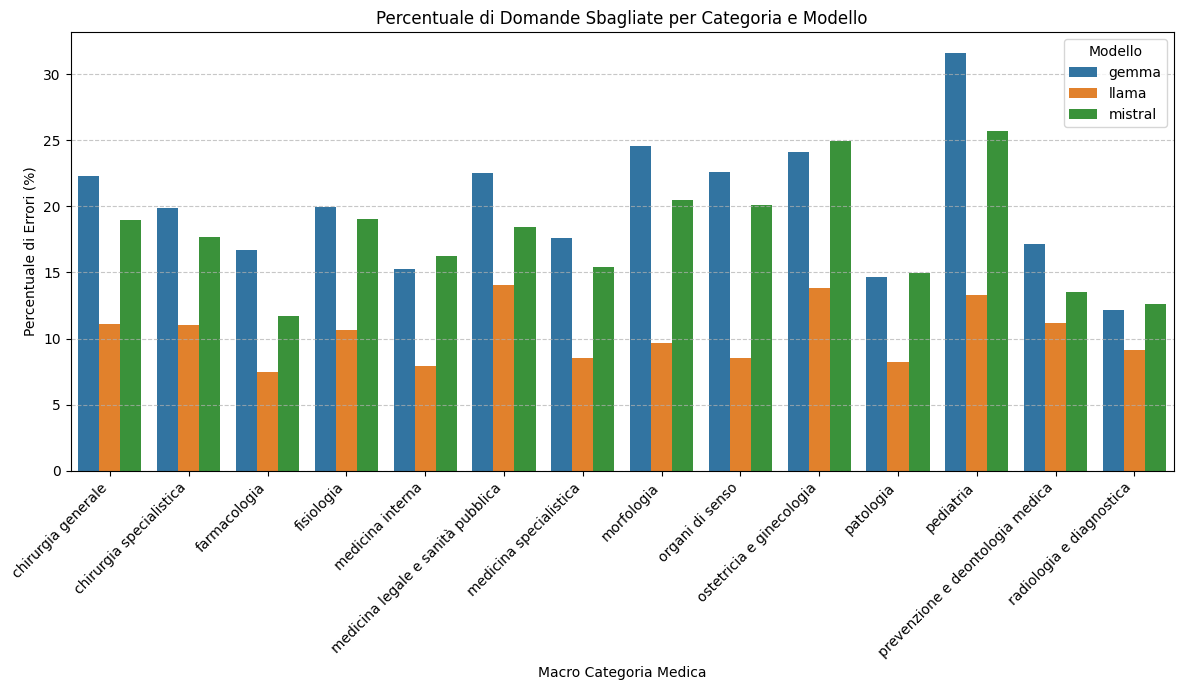

In [26]:
plt.figure(figsize=(12, 7))
sns.barplot(x='macro_category', y='error_percentage', hue='model_name', data=errors_percentage)

plt.title('Percentuale di Domande Sbagliate per Categoria e Modello')
plt.xlabel('Macro Categoria Medica')
plt.ylabel('Percentuale di Errori (%)')
plt.xticks(rotation=45, ha='right') # Ruota le etichette dell'asse x per una migliore leggibilità
plt.legend(title='Modello')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adatta il layout per evitare che le etichette si sovrappongano
plt.show()

In [27]:

# Supponiamo che tu abbia già eseguito i passaggi precedenti
# e che 'df' e 'df_errors' siano popolati come nel codice precedente.

# Conto gli errori per ogni modello e macro_category
errors_count_per_model_category = df_errors.groupby(['model_name', 'macro_category']).size().reset_index(name='error_count')

# Calcola il totale degli errori per ogni modello
total_errors_per_model = errors_count_per_model_category.groupby('model_name')['error_count'].sum().reset_index(name='total_errors')

# Merge per aggiungere il conteggio totale degli errori per ogni modello
errors_distribution = pd.merge(errors_count_per_model_category, total_errors_per_model, on='model_name', how='left')

# Calcola la percentuale della categoria sul totale degli errori del modello
errors_distribution['percentage_of_model_errors'] = (errors_distribution['error_count'] / errors_distribution['total_errors']) * 100

print("Distribuzione percentuale degli errori per categoria all'interno di ogni modello:")
print(errors_distribution.head())
print(errors_distribution.tail())

Distribuzione percentuale degli errori per categoria all'interno di ogni modello:
  model_name           macro_category  error_count  total_errors  \
0      gemma       chirurgia generale           94          1314   
1      gemma  chirurgia specialistica           45          1314   
2      gemma             farmacologia           67          1314   
3      gemma               fisiologia          234          1314   
4      gemma         medicina interna           46          1314   

   percentage_of_model_errors  
0                    7.153729  
1                    3.424658  
2                    5.098935  
3                   17.808219  
4                    3.500761  
   model_name                    macro_category  error_count  total_errors  \
37    mistral          ostetricia e ginecologia           65          1179   
38    mistral                         patologia          138          1179   
39    mistral                         pediatria           83          1179   
40   

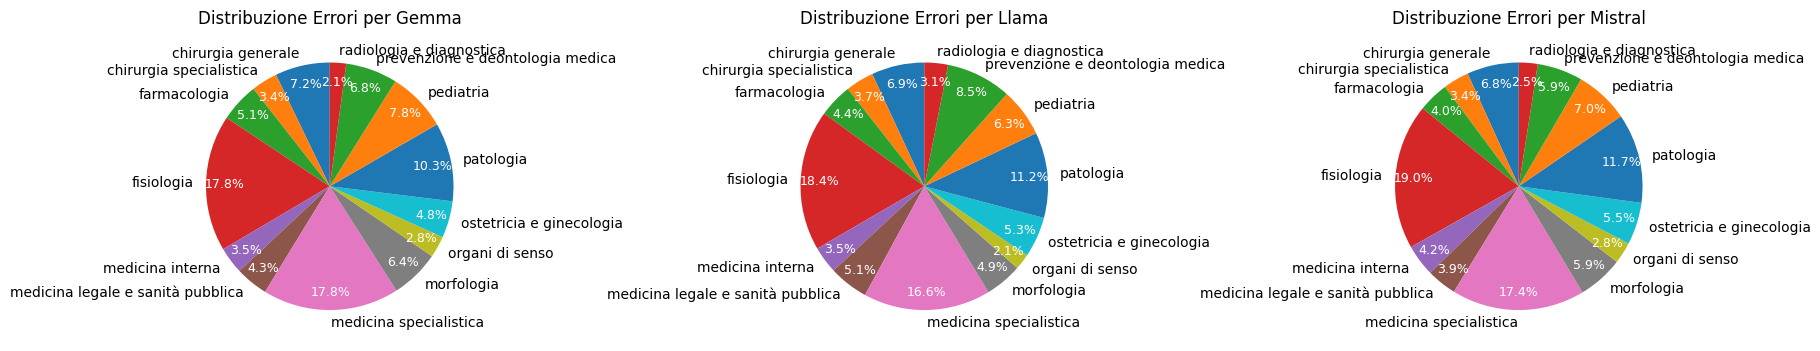

In [29]:
# Imposta la dimensione della figura.
# Se hai molti modelli, potresti voler aumentare la larghezza o altezza.
# Qui, 1 riga e 3 colonne per i tuoi 3 modelli.
fig, axes = plt.subplots(1, len(models), figsize=(18, 6)) # figsize (width, height)

# Assicurati che axes sia un array anche se c'è un solo modello
if len(models) == 1:
    axes = [axes]

# Genera un aerogramma per ogni modello
for i, model in enumerate(models):
    # Filtra i dati per il modello corrente
    model_errors_data = errors_distribution[errors_distribution['model_name'] == model]

    # Prepara i dati per l'aerogramma
    # Filtra le categorie che hanno 0 errori per quel modello per non visualizzarle
    plot_data = model_errors_data[model_errors_data['percentage_of_model_errors'] > 0]

    # Se non ci sono errori per il modello, salta il plotting o mostra un messaggio
    if plot_data.empty:
        axes[i].text(0.5, 0.5, 'Nessun errore registrato', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Errori per {model.capitalize()}')
        continue

    labels = plot_data['macro_category']
    sizes = plot_data['percentage_of_model_errors']

    # Crea l'aerogramma sul subplot corrente
    wedges, texts, autotexts = axes[i].pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%', # Formato per mostrare le percentuali
        startangle=90,
        pctdistance=0.85 # Distanza delle etichette percentuali dal centro
    )
    axes[i].set_title(f'Distribuzione Errori per {model.capitalize()}')

    # Migliora la leggibilità delle percentuali
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(9) # Puoi regolare la dimensione del font
    for text in texts:
        text.set_fontsize(10) # Dimensione del font per le etichette delle categorie

# Regola il layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()

In [30]:


# Supponendo che il tuo DataFrame 'df' sia già disponibile e strutturato come mostrato
# df = pd.read_csv('il_tuo_file.csv') # Se non lo hai già caricato

# Rinomina la colonna 'macro category' e 'category' per facilità d'uso se contengono spazi
df.rename(columns={'macro category': 'macro_category'}, inplace=True)
# df.rename(columns={'category': 'area_category'}, inplace=True) # Se 'category' è la colonna per Area Clinica/Preclinica

# Dalla tua immagine, la colonna 'category' sembra essere 'Area Preclinica 2016'.
# Assumiamo che ci sia solo "Area Preclinica" e "Area Clinica" come valori unici in questa colonna,
# o che tu voglia trattare 'Area Preclinica 2016' come "Area Preclinica" e così via.
# Se hai valori come 'Area Clinica 2016', 'Area Clinica 2017', etc., potresti voler normalizzarli:
df['main_area'] = df['category'].apply(lambda x: 'Area Preclinica' if 'Preclinica' in x else ('Area Clinica' if 'Clinica' in x else 'Altro'))


# Lista dei modelli che vuoi analizzare
models = ['gemma', 'llama', 'mistral']

# Creiamo un DataFrame vuoto per raccogliere gli errori
df_errors = pd.DataFrame()

# Iteriamo su ogni modello per trovare le risposte sbagliate
for model in models:
    errors_for_model = df[df[model] != df['answer']].copy()
    errors_for_model['model_name'] = model
    df_errors = pd.concat([df_errors, errors_for_model], ignore_index=True)

print("Anteprima del dataset degli errori con 'main_area':")
print(df_errors.head())

Anteprima del dataset degli errori con 'main_area':
   index                                           question answer  \
0     11  tutte le beta lattamine indicate sono resisten...      C   
1     19  in quale delle seguenti condizioni il trattame...      A   
2     35                   l'emivita (t ½) di un farmaco è:      C   
3     43  i benefici, ormai stabiliti, della terapia sos...      B   
4     44  attraverso quale dei seguenti meccanismi d'azi...      B   

               category macro_category gemma llama mistral        area  \
0  Area Preclinica 2016   farmacologia     D     C       C  Preclinica   
1  Area Preclinica 2016   farmacologia     E     A       A  Preclinica   
2  Area Preclinica 2016   farmacologia     E     C       B  Preclinica   
3  Area Preclinica 2016   farmacologia     E     B       B  Preclinica   
4  Area Preclinica 2016   farmacologia     A     B       A  Preclinica   

         main_area model_name  
0  Area Preclinica      gemma  
1  Area Preclinica

In [31]:
# Conto gli errori per ogni modello, area principale e macro_category
errors_count_per_model_area_category = df_errors.groupby(['model_name', 'main_area', 'macro_category']).size().reset_index(name='error_count')

# Calcola il totale degli errori per ogni modello E area principale
total_errors_per_model_area = errors_count_per_model_area_category.groupby(['model_name', 'main_area'])['error_count'].sum().reset_index(name='total_errors_in_area')

# Merge per aggiungere il conteggio totale degli errori per ogni modello e area principale
errors_distribution_by_area = pd.merge(
    errors_count_per_model_area_category,
    total_errors_per_model_area,
    on=['model_name', 'main_area'],
    how='left'
)

# Calcola la percentuale della macro_category sul totale degli errori del modello all'interno di quella main_area
errors_distribution_by_area['percentage_of_area_errors'] = (
    errors_distribution_by_area['error_count'] / errors_distribution_by_area['total_errors_in_area']
) * 100

print("\nDistribuzione percentuale degli errori per macro_category all'interno di ogni modello e area principale:")
print(errors_distribution_by_area.head())


Distribuzione percentuale degli errori per macro_category all'interno di ogni modello e area principale:
  model_name     main_area                     macro_category  error_count  \
0      gemma  Area Clinica                 chirurgia generale           94   
1      gemma  Area Clinica            chirurgia specialistica           45   
2      gemma  Area Clinica                   medicina interna           46   
3      gemma  Area Clinica  medicina legale e sanità pubblica           56   
4      gemma  Area Clinica             medicina specialistica          234   

   total_errors_in_area  percentage_of_area_errors  
0                   705                  13.333333  
1                   705                   6.382979  
2                   705                   6.524823  
3                   705                   7.943262  
4                   705                  33.191489  


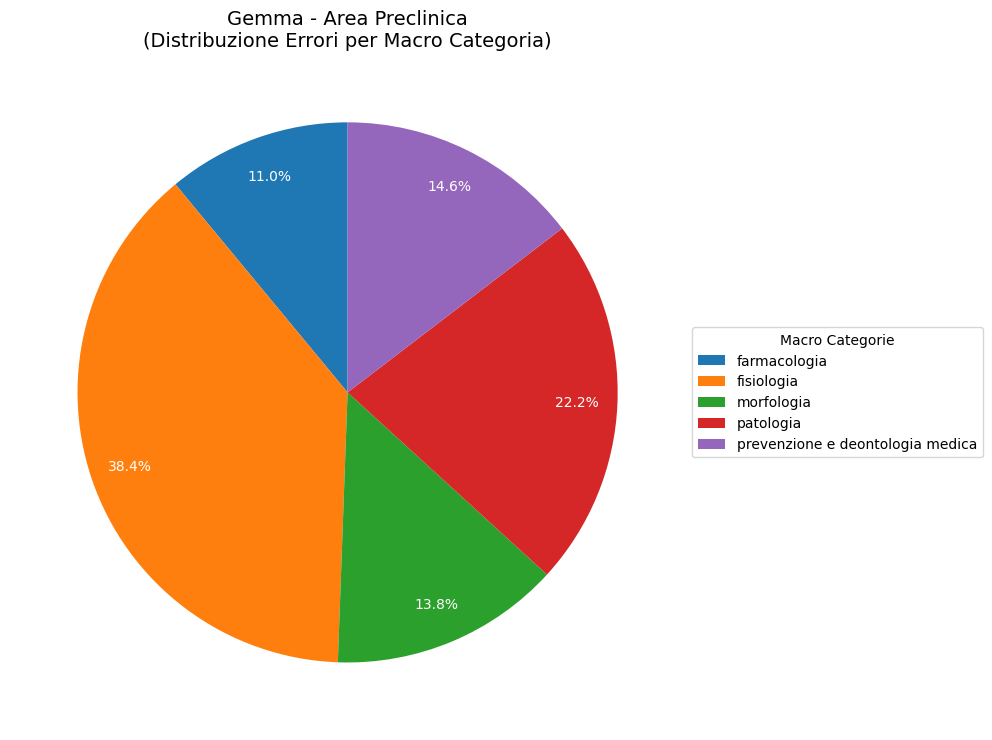

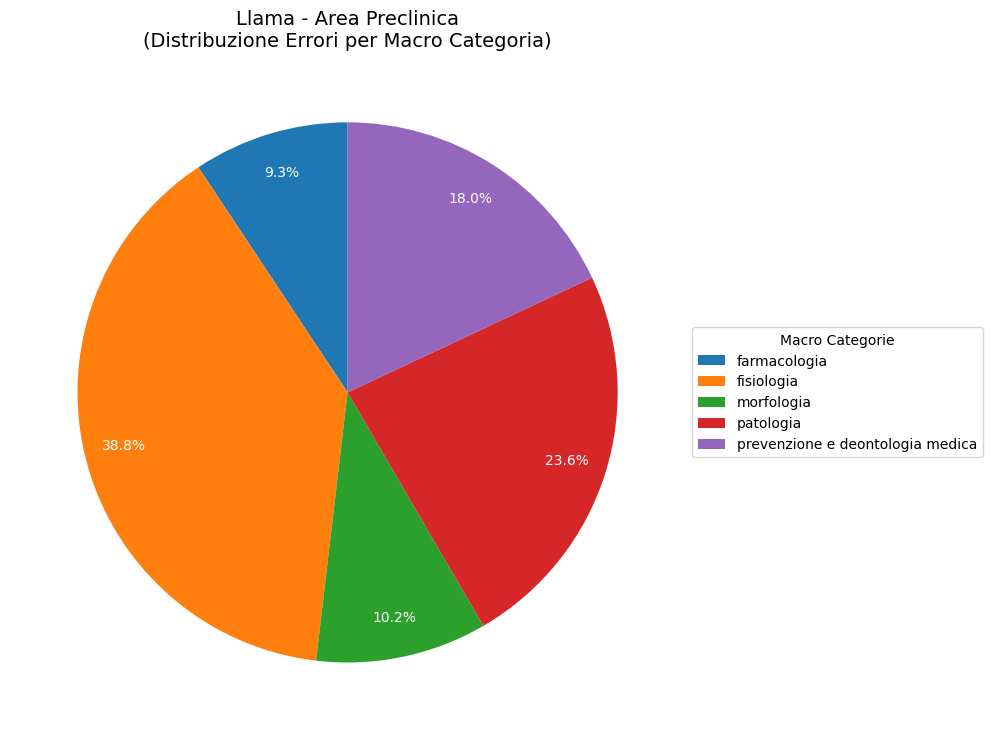

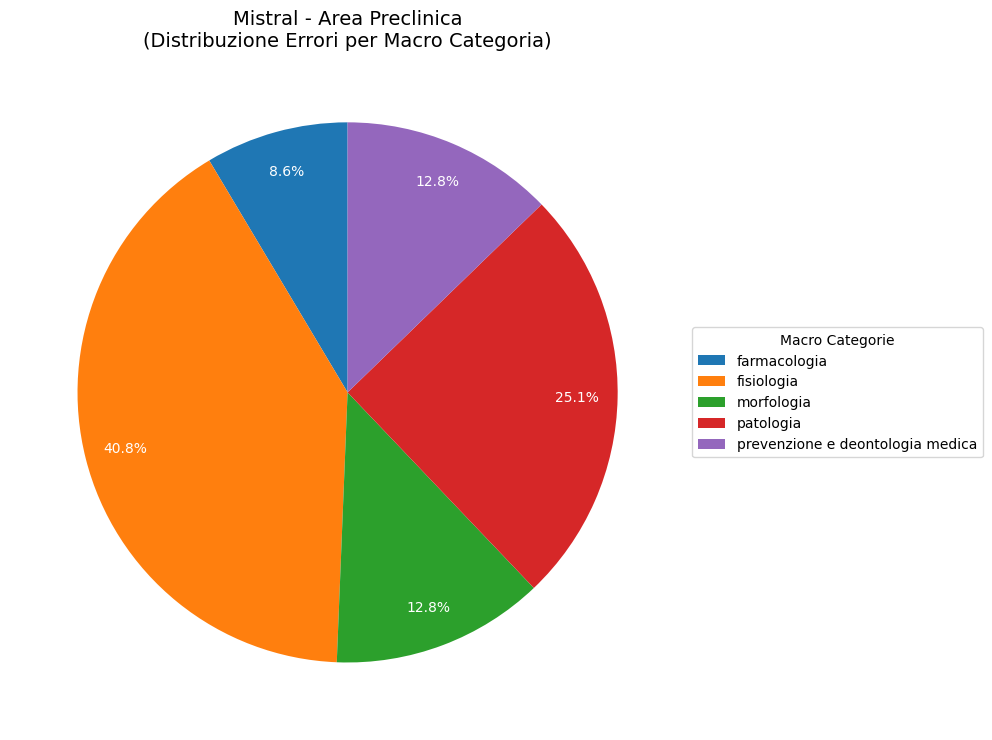

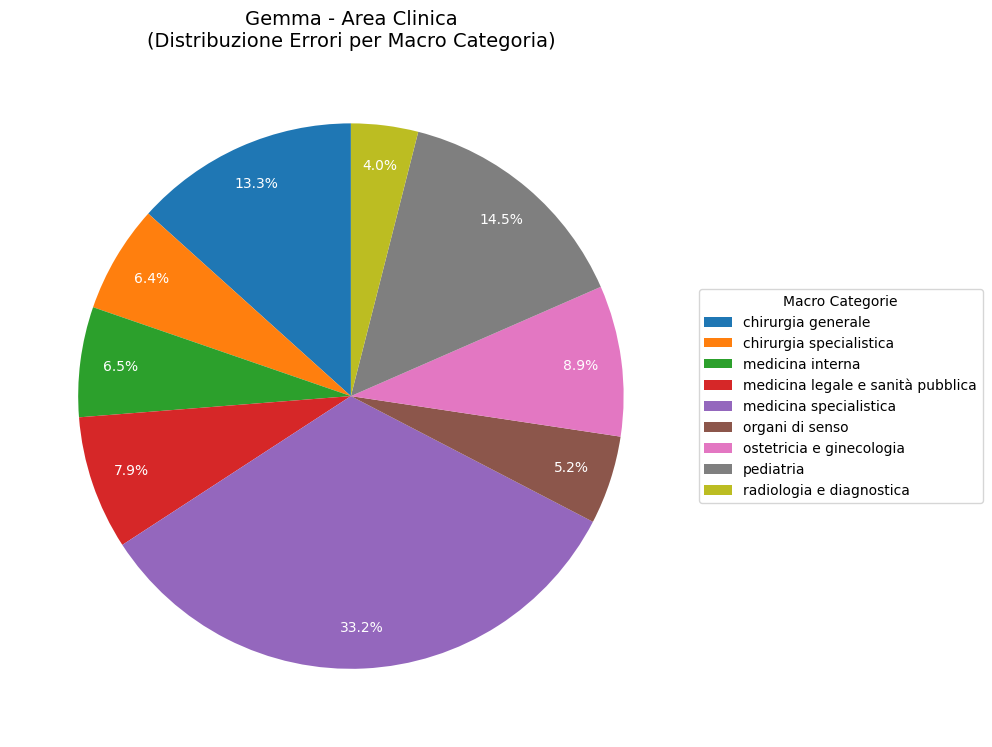

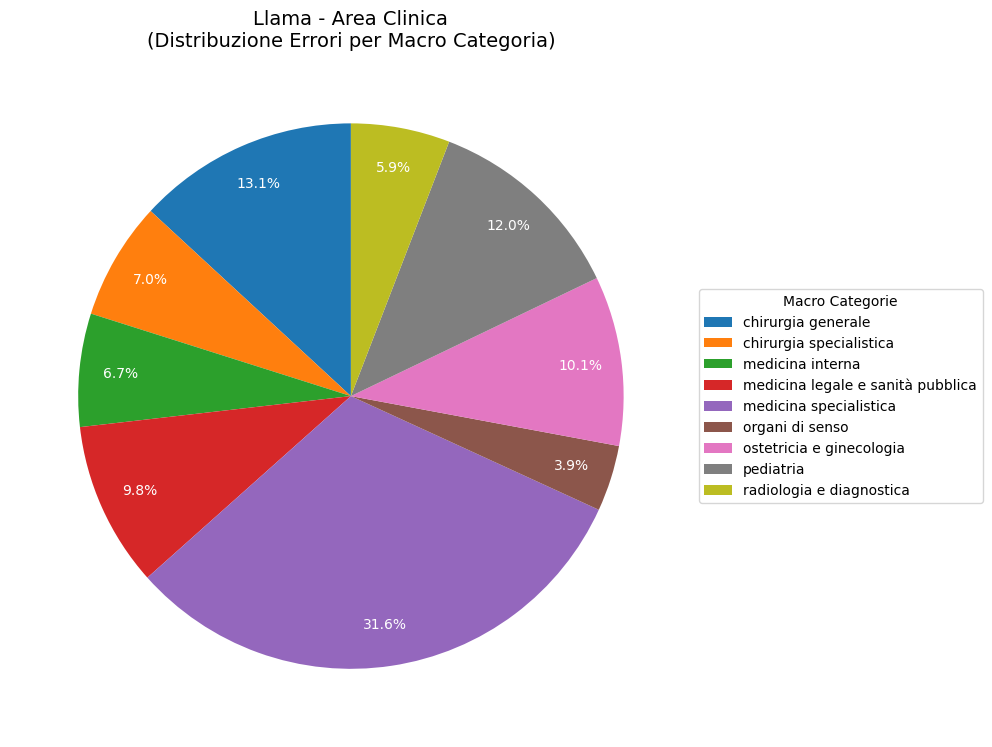

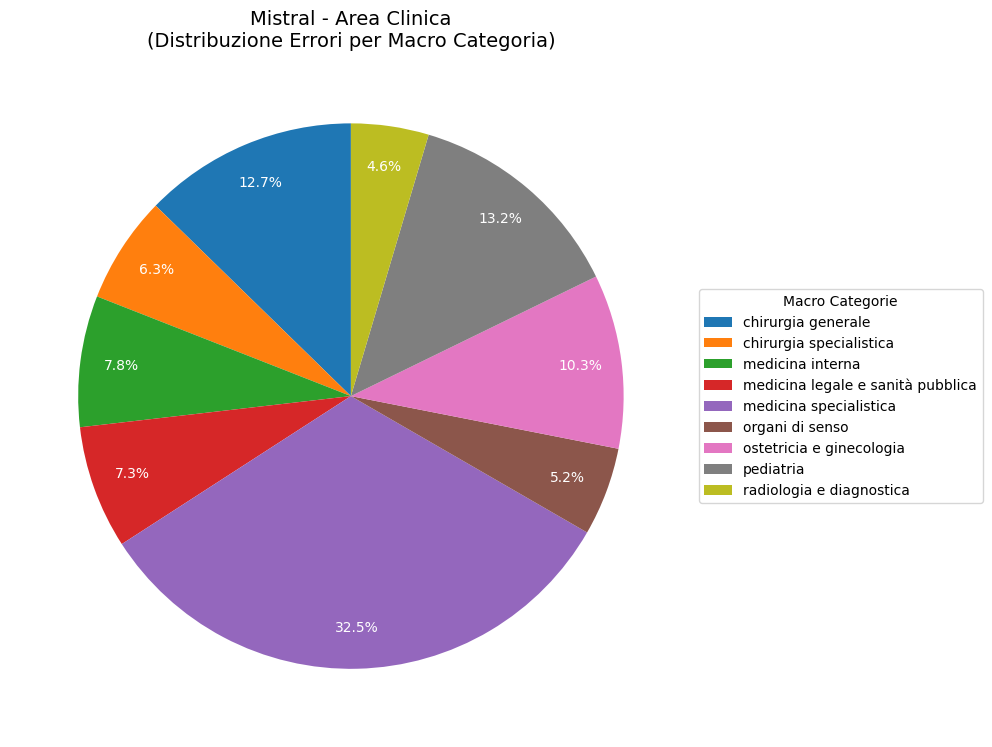

In [34]:
# Imposta una palette di colori per coerenza tra i grafici
colors = sns.color_palette('tab10', n_colors=len(df['macro_category'].unique()))

for area in main_areas:
    for model in models:
        # Filtra i dati per il modello e l'area corrente
        plot_data = errors_distribution_by_area[
            (errors_distribution_by_area['model_name'] == model) &
            (errors_distribution_by_area['main_area'] == area)
        ]

        # Filtra le categorie che hanno 0 errori in questa combinazione
        plot_data = plot_data[plot_data['percentage_of_area_errors'] > 0]

        # Crea una nuova figura e un asse per ogni aerogramma
        plt.figure(figsize=(10, 10)) # Puoi regolare la dimensione per adattarla meglio
        ax = plt.gca() # Ottieni l'asse corrente

        if plot_data.empty:
            ax.text(0.5, 0.5, 'Nessun errore registrato in questa combinazione',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=12, color='gray')
            ax.set_title(f'{model.capitalize()} - {area}\n(Distribuzione Errori per Macro Categoria)')
            ax.axis('off') # Nasconde gli assi
            plt.show() # Mostra la figura vuota
            continue

        labels = plot_data['macro_category']
        sizes = plot_data['percentage_of_area_errors']

        wedges, texts, autotexts = ax.pie(
            sizes,
            autopct='%1.1f%%', # Mostra le percentuali
            startangle=90,
            pctdistance=0.85, # Distanza delle etichette percentuali
            colors=colors # Usa la palette di colori definita
        )

        ax.set_title(f'{model.capitalize()} - {area}\n(Distribuzione Errori per Macro Categoria)', fontsize=14)

        # Migliora la leggibilità delle percentuali e delle etichette
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)
        for text in texts:
            text.set_fontsize(11) # Aumenta la dimensione del font per le etichette delle categorie

        # Aggiungi una legenda per le macro categorie
        ax.legend(
            wedges,
            labels,
            title="Macro Categorie",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1), # Posiziona la legenda fuori dal grafico a destra
            fontsize=10
        )

        plt.tight_layout() # Adatta il layout
        plt.show() # Mostra la figura corrente prima di passare alla successiva

In [45]:
# Contare quante volte ogni 'question' appare nel DataFrame df_errors
# Ogni apparizione significa che almeno un modello ha sbagliato quella domanda.
# Se una domanda è sbagliata da 3 modelli, apparirà 3 volte.

question_error_counts = df_errors['question'].value_counts().reset_index()
question_error_counts.columns = ['question', 'total_errors']

# Ordina in ordine decrescente per 'total_errors'
most_wrong_questions = question_error_counts.sort_values(by='total_errors', ascending=False)

print("\nClassifica delle Domande più Sbagliate in Assoluto (dal più sbagliato al meno sbagliato):")
print(most_wrong_questions.head) # Mostra le prime 10 domande più sbagliate


Classifica delle Domande più Sbagliate in Assoluto (dal più sbagliato al meno sbagliato):
<bound method NDFrame.head of                                                question  total_errors
0     una ipoalbuminemia selettiva puo' essere dovut...             6
1     quale esame nella diagnosi di "sindrome x" car...             6
2     quale dei seguenti sintomi è comunemente prese...             5
3     tutte le seguenti condizioni possono associars...             4
4     a quanti cm. dalla valvola ileo-cecale si repe...             4
...                                                 ...           ...
1249  quale tra le seguenti affermazioni relative al...             1
1250  quale dei seguenti non è un effetto collateral...             1
1251  durante la respirazione tranquilla la pression...             1
1252                             le ricette ripetibili:             1
1903  quale delle seguenti rappresenta la gestione p...             1

[1904 rows x 2 columns]>


## Calcolare se c'è una relazione significativa tra numero sbagliato di domande del modello e categoria della domanda

In [60]:

models = ['gemma', 'llama', 'mistral']
all_macro_categories = df['macro_category'].unique()
results_summary_final = []

print("--- Generazione delle Tabelle di Contingenza (Errori/Corrette per Modello) per Categoria ---")
print("-----------------------------------------------------------------------------------------")

# Questo loop itera attraverso OGNI SINGOLA macro_category presente nel tuo dataset.
for category_name in all_macro_categories:

    # 1. SELEZIONE DEI DATI PER LA MACRO CATEGORIA ATTUALE
    # Filtriamo il DataFrame 'df' originale per considerare SOLO le domande
    # che appartengono alla 'category_name' corrente (es. 'Cardiologia').
    df_current_category = df[df['macro_category'] == category_name].copy()

    # --- 2. CREAZIONE DELLA CONTINGENCY TABLE PER QUESTA SPECIFICA CATEGORIA ---
    # Questa tabella conterrà i conteggi di "Errori" e "Corrette" per ogni modello,
    # MA SOLO per le domande relative alla 'category_name' attuale.
    contingency_table_data = []
    for model in models:
        # Conta le risposte corrette del modello per le domande di 'category_name'
        correct_count = (df_current_category[model] == df_current_category['answer']).sum()
        # Conta le risposte sbagliate del modello per le domande di 'category_name'
        error_count = (df_current_category[model] != df_current_category['answer']).sum()
        contingency_table_data.append([error_count, correct_count])

    # Creiamo il DataFrame Pandas che rappresenta la nostra contingency table
    # con i nomi dei modelli come indice e 'Errori'/'Corrette' come colonne.
    contingency_table = pd.DataFrame(contingency_table_data, index=models, columns=['Errori', 'Corrette'])

    # --- STAMPA DELLA TABELLA DI CONTINGENZA ATTUALE ---
    print(f"\n#####################################################")
    print(f"### Tabella di Contingenza per: '{category_name}' ###")
    print(f"#####################################################")
    print(contingency_table)
    print("\n" + "="*50) # Separatore visivo

    # A questo punto, se volessi, potresti eseguire il test Chi-quadro QUI,
    # SUBITO DOPO aver stampato la tabella, come negli script precedenti.
    # Esempio (non eseguito in questo blocco, ma per riferimento):
    chi2_val, p_val, dof_val, expected_freq = chi2_contingency(contingency_table)
    print(f"P-value per '{category_name}': {p_val:.4f}")

    results_summary_final.append({
        'Macro_Category': category_name,
        'Chi2_Statistic': chi2_val,
        'P_Value': p_val,
        'Degrees_of_Freedom': dof_val,
    })

    print("\n" + "="*80) # Separatore visivo più lungo per chiarezza tra le categorie

# --- TABELLA RIEPILOGATIVA FINALE ---
print("\n\n--- RIEPILOGO COMPLESSIVO DEI TEST CHI-QUADRO PER CATEGORIA ---")
print("------------------------------------------------------------------")
results_df_final = pd.DataFrame(results_summary_final)
print(results_df_final.round(4)) # Arrotonda i valori per una migliore leggibilità

# Opzionale: salva il riepilogo in un file CSV
# results_df_final.to_csv('chi_square_summary_all_categories.csv', index=False)




--- Generazione delle Tabelle di Contingenza (Errori/Corrette per Modello) per Categoria ---
-----------------------------------------------------------------------------------------

#####################################################
### Tabella di Contingenza per: 'farmacologia' ###
#####################################################
         Errori  Corrette
gemma        67       334
llama        30       371
mistral      47       354

P-value per 'farmacologia': 0.0003


#####################################################
### Tabella di Contingenza per: 'fisiologia' ###
#####################################################
         Errori  Corrette
gemma       234       940
llama       125      1049
mistral     224       950

P-value per 'fisiologia': 0.0000


#####################################################
### Tabella di Contingenza per: 'morfologia' ###
#####################################################
         Errori  Corrette
gemma        84       258
llama    

## togliamo llama perchè è molto meglio degli altri

In [61]:
# --- LISTA DEI MODELLI AGGIORNATA: ESCLUDE LLAMA ---
models_to_analyze = ['gemma', 'mistral'] # Solo Gemma e Mistral

# Otteniamo tutte le macro categorie uniche presenti nel tuo dataset
all_macro_categories = df['macro_category'].unique()

print("--- AVVIO DEI TEST CHI-QUADRO PER OGNI MACRO CATEGORIA (Escludendo Llama) ---")
print("-------------------------------------------------------------------------")

# Livello di significatività per i test (comunemente 0.05)
alpha = 0.05

# Lista per memorizzare i risultati di ogni test (per un riepilogo finale)
results_summary_no_llama = []

# --- INIZIO DEL LOOP PRINCIPALE ---
for category_name in all_macro_categories:

    df_current_category = df[df['macro_category'] == category_name].copy()

    contingency_table_data = []
    for model in models_to_analyze: # <-- Iteriamo solo sui modelli selezionati
        correct_count = (df_current_category[model] == df_current_category['answer']).sum()
        error_count = (df_current_category[model] != df_current_category['answer']).sum()
        contingency_table_data.append([error_count, correct_count])

    contingency_table = pd.DataFrame(contingency_table_data, index=models_to_analyze, columns=['Errori', 'Corrette'])

    print(f"\n#####################################################")
    print(f"### Analisi per la Macro Categoria: '{category_name}' (vs Gemma & Mistral) ###")
    print(f"#####################################################")

    print(f"\nTabella di Contingenza per '{category_name}':")
    print(contingency_table)

    if contingency_table.sum().sum() == 0: # Gestione caso senza dati
        print("ATTENZIONE: Nessun dato per questa categoria. Salto il test Chi-quadro.")
        chi2_val, p_val, dof_val = np.nan, np.nan, np.nan
        is_significant = np.nan
    else:
        # Esegui il test Chi-quadro
        chi2_val, p_val, dof_val, expected_freq = chi2_contingency(contingency_table)

        print(f"\nRisultati del Test Chi-quadro per '{category_name}':")
        print(f"  Statistica Chi-quadro: {chi2_val:.2f}")
        print(f"  Gradi di libertà (dof): {dof_val}")
        print(f"  P-value: {p_val:.4f}")

        if p_val < alpha:
            print(f"  Conclusione: Il p-value ({p_val:.4f}) è minore di {alpha}.")
            print(f"  RISULTATO: Statistica SIGNIFICATIVA. Esiste una relazione tra Gemma e Mistral e la loro performance (corretto/errato) in '{category_name}'.")
            print(f"  Le differenze nelle percentuali di errore tra Gemma e Mistral in questa categoria NON sono casuali.")
            is_significant = True
        else:
            print(f"  Conclusione: Il p-value ({p_val:.4f}) è maggiore o uguale a {alpha}.")
            print(f"  RISULTATO: Statistica NON SIGNIFICATIVA. Non c'è una relazione tra Gemma e Mistral e la loro performance (corretto/errato) in '{category_name}'.")
            print(f"  Le differenze nelle percentuali di errore tra Gemma e Mistral in questa categoria potrebbero essere dovute al caso.")
            is_significant = False

    results_summary_no_llama.append({
        'Macro_Category': category_name,
        'Chi2_Statistic': chi2_val,
        'P_Value': p_val
    })

print("\n\n--- RIEPILOGO FINALE DI TUTTI I TEST CHI-QUADRO PER CATEGORIA (Escludendo Llama) ---")
print("----------------------------------------------------------------------------------")
results_df_summary_no_llama = pd.DataFrame(results_summary_no_llama)
print(results_df_summary_no_llama.round(4))

# Puoi anche salvare questo riepilogo in un file CSV
# results_df_summary_no_llama.to_csv('chi_square_results_summary_no_llama.csv', index=False)

--- AVVIO DEI TEST CHI-QUADRO PER OGNI MACRO CATEGORIA (Escludendo Llama) ---
-------------------------------------------------------------------------

#####################################################
### Analisi per la Macro Categoria: 'farmacologia' (vs Gemma & Mistral) ###
#####################################################

Tabella di Contingenza per 'farmacologia':
         Errori  Corrette
gemma        67       334
mistral      47       354

Risultati del Test Chi-quadro per 'farmacologia':
  Statistica Chi-quadro: 3.69
  Gradi di libertà (dof): 1
  P-value: 0.0547
  Conclusione: Il p-value (0.0547) è maggiore o uguale a 0.05.
  RISULTATO: Statistica NON SIGNIFICATIVA. Non c'è una relazione tra Gemma e Mistral e la loro performance (corretto/errato) in 'farmacologia'.
  Le differenze nelle percentuali di errore tra Gemma e Mistral in questa categoria potrebbero essere dovute al caso.

#####################################################
### Analisi per la Macro Categoria